In [11]:
import os, re
import pandas as pd

DATA_ROOT = r"C:\Users\damen\Desktop\football-main"
YEARS = list(range(2016, 2025))        # 2016..2024
POSITIONS = ["QB", "RB", "WR", "TE"]

In [12]:
def _clean_actuals(df):
    out = df.copy()
    out["Player_clean"] = out["Player"].astype(str).str.replace(r"\s*\(.*\)", "", regex=True)
    return out.rename(columns={"FPTS": "actual_points"})

def load_year_pos(year:int, pos:str) -> pd.DataFrame | None:
    """Return merged df with year,pos,player,position_rank,points,actual_points,error."""
    proj_path = fr"{DATA_ROOT}\Projections\projections_{year}_wk0.csv"
    act_path  = fr"{DATA_ROOT}\Actuals\{pos} Stats\{year} {pos} Stats"
    if not (os.path.exists(proj_path) and os.path.exists(act_path)):
        return None

    proj = pd.read_csv(proj_path)[["player","position","points","position_rank"]]
    act  = _clean_actuals(pd.read_csv(act_path))

    m = proj.merge(act, left_on="player", right_on="Player_clean", how="inner")
    if m.empty: 
        return None

    m = m.rename(columns={"position":"pos"})
    m["year"] = year
    m["pos"] = pos
    m["error"] = m["points"] - m["actual_points"]
    return m[["year","pos","player","position_rank","points","actual_points","error"]]

def load_all(years=YEARS, positions=POSITIONS) -> pd.DataFrame:
    frames = []
    for y in years:
        for p in positions:
            df = load_year_pos(y, p)
            if df is not None:
                frames.append(df)
    return pd.concat(frames, ignore_index=True)

In [13]:
def calc_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns per year/pos metrics: bias, reliability, over/under %.
    Reliability = 1 - (std(error) / mean(actual_points))
    """
    g = df.groupby(["year","pos"], as_index=False)
    out = g.apply(lambda gdf: pd.Series({
        "bias": (gdf["points"].mean() - gdf["actual_points"].mean()) / gdf["points"].mean(),
        "reliability": 1 - (gdf["error"].std() / gdf["actual_points"].mean()),
        "overperform_pct": (gdf["actual_points"] > gdf["points"]).mean(),
        "underperform_pct": (gdf["actual_points"] < gdf["points"]).mean()
    })).reset_index(drop=True)
    return out

In [14]:
# A) Fixed tiers — edit thresholds if you like
FIXED_TIER_BOUNDS = {
    "QB":  [12, 24, 36, 48],      # T1:1-12, T2:13-24, etc.
    "RB":  [12, 24, 36, 48],
    "WR":  [12, 24, 36, 48, 60, 72],
    "TE":  [6, 12, 24, 36, 48]
}

def assign_fixed_tier(row) -> int:
    bounds = FIXED_TIER_BOUNDS[row["pos"]]
    rank = int(row["position_rank"])
    tier = 1
    for b in bounds:
        if rank <= b:
            return tier
        tier += 1
    return tier

def add_fixed_tiers(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["tier_fixed"] = out.apply(assign_fixed_tier, axis=1)
    return out

In [15]:
# B) Gap tiers — break when projected-point drop exceeds threshold
def add_gap_tiers(df: pd.DataFrame, gap_threshold: float = 10.0) -> pd.DataFrame:
    out = df.copy()
    out["tier_gap"] = 0
    for (y,p), g in out.groupby(["year","pos"]):
        g = g.sort_values("position_rank").reset_index()
        tier = 1
        out.loc[g.loc[0,"index"], "tier_gap"] = tier
        for i in range(1, len(g)):
            gap = g.loc[i-1, "points"] - g.loc[i, "points"]
            if gap > gap_threshold:
                tier += 1
            out.loc[g.loc[i,"index"], "tier_gap"] = tier
    return out


In [16]:
def pos_slot_group(rank: int) -> str:
    if rank <= 12:  return "Top 12"
    if rank <= 24:  return "13–24"
    if rank <= 36:  return "25–36"
    if rank <= 48:  return "37–48"
    return "49+"

def summarize_slot_groups(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["slot_group"] = d["position_rank"].astype(int).apply(pos_slot_group)
    agg = (d.groupby(["pos","slot_group"])
             .apply(lambda g: pd.Series({
                 "overperform_pct": (g["actual_points"] > g["points"]).mean(),
                 "avg_bias": (g["points"].mean() - g["actual_points"].mean()) / g["points"].mean(),
                 "reliability": 1 - (g["error"].std() / g["actual_points"].mean())
             }))
             .reset_index())
    return agg


In [17]:
all_players = load_all()                    # every player-year-pos merged
metrics_by_year_pos = calc_metrics(all_players)
players_with_tiers = add_fixed_tiers(add_gap_tiers(all_players, gap_threshold=10.0))
slot_summary_all_years = summarize_slot_groups(all_players)

# Quick sanity peeks:
print(metrics_by_year_pos.head())
print(slot_summary_all_years.head())

# Example: current-year tiers you’ll actually draft from
tiers_2024_wr = players_with_tiers[(players_with_tiers.year==2024) & (players_with_tiers.pos=="WR")][
    ["player","position_rank","points","actual_points","tier_fixed","tier_gap"]
].sort_values("position_rank")
print(tiers_2024_wr.head(25))

   year pos      bias  reliability  overperform_pct  underperform_pct
0  2016  QB  0.202725     0.665325         0.117647          0.882353
1  2016  RB  0.146931     0.332089         0.421875          0.578125
2  2016  TE  0.310118     0.283581         0.200000          0.800000
3  2016  WR  0.163942     0.532747         0.349206          0.650794
4  2017  QB  0.273005     0.603234         0.212121          0.787879
  pos slot_group  overperform_pct  avg_bias  reliability
0  QB      13–24         0.093458  0.313752     0.564927
1  QB      25–36         0.339806  0.196853     0.385457
2  QB     Top 12         0.127451  0.203407     0.750356
3  RB      13–24         0.313131  0.169203     0.590729
4  RB      25–36         0.294737  0.203094     0.505067
                   player  position_rank  points  actual_points  tier_fixed  \
1686          CeeDee Lamb              1   347.0          263.4           1   
1687          Tyreek Hill              2   334.0          218.2           1   
1

C:\Users\damen\AppData\Local\Temp\ipykernel_37784\608914189.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda gdf: pd.Series({
C:\Users\damen\AppData\Local\Temp\ipykernel_37784\1474271379.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  "reliability": 1 - (g["error"].std() / g["actual_points"].mean())
C:\Users\damen\AppData\Local\Temp\ipykernel_37784\1474271379.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping

C:\Users\damen\AppData\Local\Temp\ipykernel_37784\3401167750.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


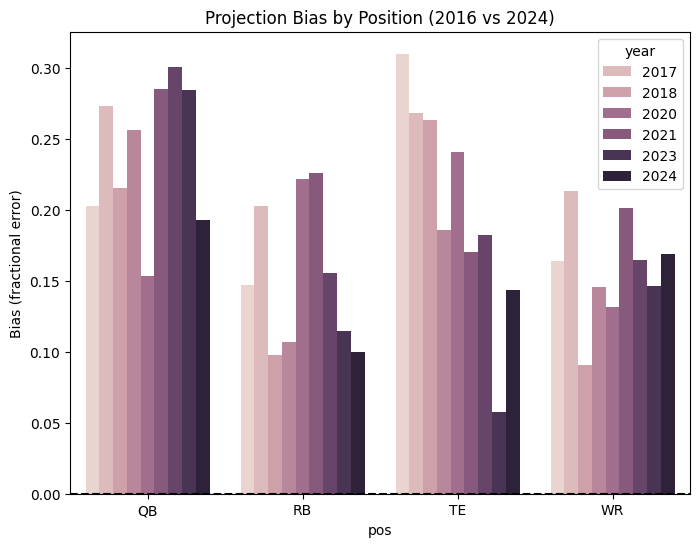

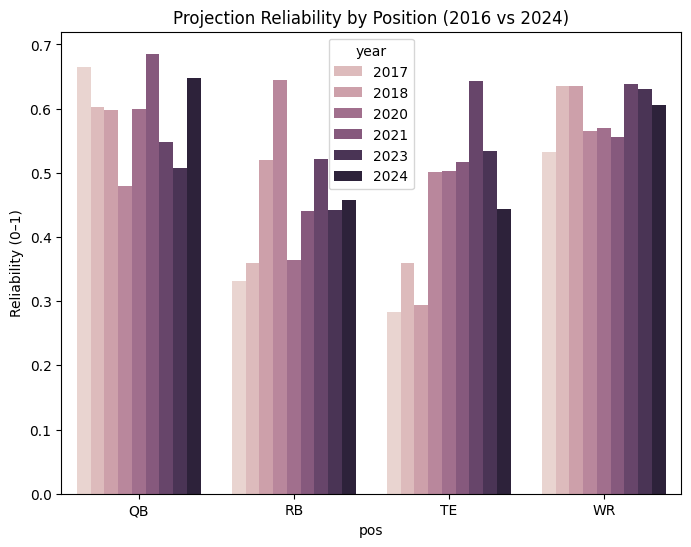

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Summarize ---
summary = (
    all_players.groupby(['year','pos'])
    .apply(lambda g: pd.Series({
        'bias': (g['points'].mean() - g['actual_points'].mean()) / g['points'].mean(),
        'reliability': 1 - (g['error'].std() / g['actual_points'].mean())
    }))
    .reset_index()
)

# --- Visual 1: Bias ---
plt.figure(figsize=(8,6))
sns.barplot(data=summary, x='pos', y='bias', hue='year')
plt.axhline(0, color='black', linestyle='--')
plt.title("Projection Bias by Position (2016 vs 2024)")
plt.ylabel("Bias (fractional error)")
plt.show()

# --- Visual 2: Reliability ---
plt.figure(figsize=(8,6))
sns.barplot(data=summary, x='pos', y='reliability', hue='year')
plt.title("Projection Reliability by Position (2016 vs 2024)")
plt.ylabel("Reliability (0–1)")
plt.show()

# --- Visual 3: Tiers (example: WR 2024) ---
wr2024 = all_players[(all_players['year']==2024) & (all_players['pos']=='WR')]
wr2024 = wr2024.sort_values('position_rank').reset_index(drop=True)

wr2024['tier'] = 1
tier = 1
for i in range(1, len(wr2024)):
    gap = wr2024.loc[i-1,'points'] - wr2024.loc[i,'points']
    if gap > 20:  # adjustable threshold
        tier += 1
    wr2024.loc[i,'tier'] = tier
